In [1]:
import numpy as np
import pandas as pd
import os
import joblib
from elephant.gpfa import GPFA
import quantities as pq
import neo
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from kneed import KneeLocator
import scipy

# DO NOT CHANGE THIS
delay_fromstart2_1stTTL = [4.3055] # 3rd LED pulse starts from 4.3055-4.4073 (first TTL signal train)
# delay_fromstart2_1stLED = [x]




ks_dir = 'Z:/KH282_BL6/ephys/061721/2021-06-17_14-31-22/Record Node 101/experiment2/recording1/continuous/Neuropix-PXI-100.0'
behav_dir = 'Z:/Helen_neuro_behavior/0617'    
    
class load_kilsort:

    def __init__(self, path):
        self.path = path

    def load_spike_times(self):
        return np.load(str.join('', (self.path, '/spike_times.npy')))

    def load_spike_clusters(self):
        return np.load(str.join('', (self.path, '/spike_clusters.npy')))

    def load_cluster_labels(self):
        return pd.read_csv(str.join('', (self.path, '/cluster_group.tsv')), sep="\t")

    def load_cluster_info(self):
        return pd.read_csv(str.join('', (self.path, '/cluster_info.tsv')), sep="\t")

    def load_channel_map(self):
        return np.load(str.join('', (self.path, '/channel_map.npy')))

    def load_templates(self):
        return np.load(str.join('', (self.path, '/templates.npy')))
    
    
class kilosort2_spike_trains:

    def __init__(self):
        self.path = ks_dir
        spike_loader = load_kilsort(self.path)
        self.spike_times = spike_loader.load_spike_times()
        self.clusters = spike_loader.load_spike_clusters()
        self.cluster_labels = spike_loader.load_cluster_labels()
        self.channel_map = spike_loader.load_channel_map()
        self.cluster_info = spike_loader.load_cluster_info()
        self.templates = spike_loader.load_templates()
        self.good_clusters = []
        try:
            with open(os.path.join(self.path, '_removed_neuron.sav'), 'rb') as fr:
                removed_neurons = joblib.load(fr)
                self.removed_neurons = removed_neurons[0]
        except FileNotFoundError:
            self.removed_neurons = []

    def find_neurons(self):
        mua = 'No'
        if mua == 'Yes':
            for i, neuron in enumerate(np.unique(self.cluster_labels['cluster_id'])):
                if self.cluster_labels['group'][i] == 'good' or self.cluster_labels['group'][i] == 'mua' \
                        and neuron not in self.removed_neurons:
                    self.good_clusters.append(neuron)
        elif mua == 'No':
            for i, neuron in enumerate(np.unique(self.cluster_labels['cluster_id'])):
                if self.cluster_labels['group'][i] == 'good':
                    self.good_clusters.append(neuron)

    def show_templates(self):
        fig, axs = plt.subplots(len(self.good_clusters) // 5 + 1, 5, figsize=(16, 12))
        axs = axs.ravel()
        for i, neuron in enumerate(self.good_clusters):
            axs[i].plot(self.templates[neuron][:, np.where(
                self.channel_map[:][0] == self.cluster_info['ch'][np.where(self.cluster_info['id'] == neuron)[
                                              0][0]])[0][0]], c='black', label=neuron)
            axs[i].text(1, 0, '{}'.format(self.cluster_info['fr'][np.where(self.cluster_info['id'] == neuron)[
                                              0][0]]), horizontalalignment='center',
                        verticalalignment='center', transform=axs[i].transAxes)
#             axs[i].legend()
        plt.show()

    def main(self):
        self.find_neurons()
        self.show_templates()
        return self.spike_times, self.clusters, self.good_clusters


class load_behavior:
    
    def __init__(self):
        self.path = behav_dir
        self.csv_list = []
        self.name_list = []
        
    def load(self):
        for names in os.listdir(self.path):
            if names.endswith(".csv"):
                df = pd.read_csv(os.path.join(behav_dir, names))
                self.csv_list.append(df)
                self.name_list.append(names.partition('_')[2])
        
    def main(self):
        self.load()
        return self.csv_list, self.name_list
    



In [2]:
kilosortloader = load_kilsort(ks_dir)
clusterinfo = kilosortloader.load_cluster_info()

In [ ]:
clustertype = clusterinfo['group']=='good'
clusterdepth = clusterinfo['depth'][np.where(clustertype == True)[0]]

In [ ]:
clusterinfo['fr'] > 0.5

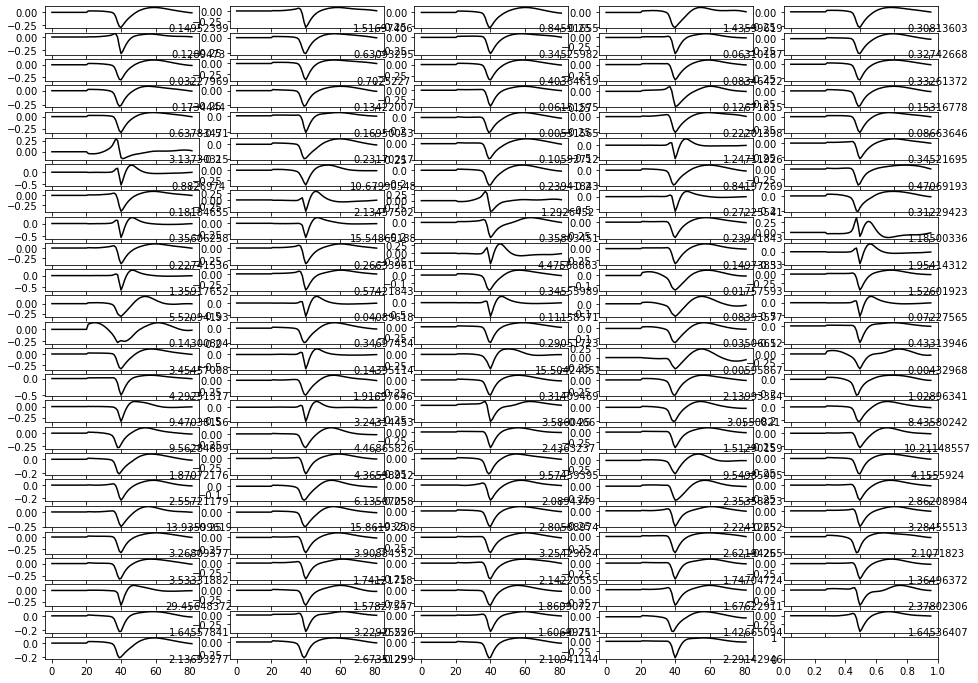

In [3]:
# load kilosort spike-sorted units and show templates for good clusters (number written on each panel is average firing rate)
spike_trains_loader = kilosort2_spike_trains()
spike_times, clusters, good_clusters = spike_trains_loader.main()

In [ ]:
# go through the list of good clusters neuron
for i, neuron in enumerate(good_clusters):
    print(i, neuron)

In [ ]:
# print the array size for spike times and its corresponding neuron number
print(spike_times.shape, clusters.shape)

In [ ]:
clusters[:50]

In [ ]:
spike_times[:50]/30000 # divide by sampling rate (30k) gives the actual time.

In [4]:
# load up the csv files (list) in the behavior directory 
behav_loader = load_behavior()
behavior_list, name_list = behav_loader.main()
print(len(behavior_list)) # print number of loaded csv files
print(name_list)

16
['groom - start_time_1.csv', 'groom - start_time_2.csv', 'groom - start_time_3.csv', 'groom - start_time_4.csv', 'itch - start_time_1.csv', 'itch - start_time_2.csv', 'itch - start_time_3.csv', 'itch - start_time_4.csv', 'locomotion - start_time_1.csv', 'locomotion - start_time_2.csv', 'locomotion - start_time_3.csv', 'locomotion - start_time_4.csv', 'rear - start_time_1.csv', 'rear - start_time_2.csv', 'rear - start_time_3.csv', 'rear - start_time_4.csv']


In [ ]:
for names in name_list:
    if 'groom' in names:
        print(names.partition(' ')[0])

In [ ]:
for i, name in enumerate(name_list):
    print(i, name)

In [5]:
# delay = delay_fromstart2_1stTTL - delay_fromstart2_1stLED
#delay = 4.8445

# delay = cam 4 start + cam 4 frame delay - neural data third pulse = delay between cam 4 and neural
#        = 37880 + 236/60 - 37879.1762
delay = 4.75713 # seconds

# don't change this
framerate = 60
time_window = [-0.5, 1]
sample_rate = 30000
# 1st segment camera 4, third LED peak
cam4_start_seg1 = 37880
# video start times for 4 segments, camera 4
video_Starttime = [37880, 46176, 53390, 57719]
# frames to third LED peak for 4 segments, camera 4
frames2LED_sincestart = [236, 258, 434, 399]
# example behavior -- grooming type a
# first_beh_since_LED = 205.4

trimmed_off = 37884
# neural_LED_sincestart = video_Starttime + frames2LED_sincestart/framerate - delay

# first_beh_since_neural_recording = neural_LED_sincestart + first_beh_since_LED

## segment 1
# neural data starts from 37884, neural data is delayed from cam4 by 4.75713 seconds 
# behavior from cam4 that starts at 10s, will be 37890. neural data will be 37890-4.75713 -> absolute time
# neural data in seconds that corresponds to 10s (behavior) is actually 37890 - 4.75713 - 37884 -> relative time (trimmed off time)

## segment 2
# neural data starts from 37884, neural data is delayed from cam4 by 4.75713 seconds
# behavior from cam4 that starts at 10s, will be 46186. neural data will be 46186-4.75713 -> absolute time
# neural data in seconds that corresponds to 10s (behavior) is actually 46186 - 4.75713 - 37884 -> relative time (trimmed off time)


# ## segment 1
# for behavior_time in behavior_list[n]['start_time']:
#     neural_time = video_Starttime[0] + behavior_time - delay - trimmed_off
#     print(neural_time)

    
# ## segment 2
# for behavior_time in behavior_list[n]['start_time']:
#     neural_time = video_Starttime[1] + behavior_time - delay - trimmed_off
#     print(neural_time)


In [8]:
# for all PSTHs
time_window_width = 1.5 #seconds
bin_width = 0.01 #50 ms
bin_count = 150
bin_times = (np.arange(bin_count)) * time_window_width / bin_count - time_window_width / 3

In [ ]:
# ## segment 1
# for behavior_time in behavior_list[n]['start_time']:
#     neural_time = video_Starttime[count] + behavior_time - delay - trimmed_off
#     print(neural_time)

    
# prints out individual groom type start times
allseg_psthlist = []
psth_list = []
count = 0
for n, name in enumerate(name_list):
    allgroom_psthlist = []
    if 'groom' in name:
        
        print(count)
        
        
        types = ['a', 'h', 's', 'b']
#        types = ['a']
        
        #print(neural_LED_sincestart)
        for ty in types:
            find_t = behavior_list[n]['type'] == ty
            for i in range(len(np.where(find_t == True)[0])):
                print('groom type ', ty, ' : ', behavior_list[n]['start_time'][np.where(find_t == True)[0][i]])
#                 neural_LED_sincestart = video_Starttime + frames2LED_sincestart/framerate - delay
                #first_beh_since_neural_recording = neural_LED_sincestart + behavior_list[n]['start_time'][np.where(find_t == True)[0][i]]
                neural_time = video_Starttime[count] + behavior_list[n]['start_time'][np.where(find_t == True)[0][i]] - delay - trimmed_off
                min_bound = np.where(spike_times/sample_rate >= neural_time + time_window[0])[0]
                max_bound = np.where(spike_times/sample_rate <= neural_time + time_window[1])[0]
        #         print(first_beh_since_neural_recording)
                print(neural_time)
                d = {'spike_times': np.concatenate(
                    spike_times[min_bound[0]:max_bound[-1]])/30000 - spike_times[min_bound[0]]/30000
                     , 'neuron_id': np.concatenate(clusters[min_bound[0]:max_bound[-1]]), 'behavior': ty}
#                 print(d)
                df = pd.DataFrame(data=d)
                psth_list.append(df)
        count += 1  
#             allgroom_psthlist.append(psth_list)
#         allseg_psthlist.append(allgroom_psthlist)
        
        

In [ ]:
len(psth_list)

In [ ]:

# # prints out individual groom type start times
# allseg_psthlist = []
# psth_list = []
# count = 0
# for n, name in enumerate(name_list):
#     allgroom_psthlist = []
#     if 'groom - start_time_1' in name:
        
#         print(count)
#         neural_LED_sincestart = video_Starttime[count] - cam4_start_seg1 + \
#                                 frames2LED_sincestart[count]/framerate - delay
#         count += 1
# #         types = ['a', 'h', 's', 'b']
#         types = ['a']
        
#         print(neural_LED_sincestart)
#         for ty in types:
#             find_t = behavior_list[n]['type'] == ty
#             for i in range(len(np.where(find_t == True)[0])):
#                 print('groom type ', ty, ' : ', behavior_list[n]['start_time'][np.where(find_t == True)[0][i]])
# #                 neural_LED_sincestart = video_Starttime + frames2LED_sincestart/framerate - delay
#                 first_beh_since_neural_recording = neural_LED_sincestart + behavior_list[n]['start_time'][np.where(find_t == True)[0][i]]
                
#                 min_bound = np.where(spike_times/sample_rate >= first_beh_since_neural_recording + time_window[0])[0]
#                 max_bound = np.where(spike_times/sample_rate <= first_beh_since_neural_recording + time_window[1])[0]
#         #         print(first_beh_since_neural_recording)
#                 d = {'spike_times': np.concatenate(
#                     spike_times[min_bound[0]:max_bound[-1]])/30000 - spike_times[min_bound[0]]/30000
#                      , 'neuron_id': np.concatenate(clusters[min_bound[0]:max_bound[-1]]), 'behavior': ty}
# #                 print(d)
#                 df = pd.DataFrame(data=d)
#                 psth_list.append(df)
# #             allgroom_psthlist.append(psth_list)
# #         allseg_psthlist.append(allgroom_psthlist)
        
        

In [ ]:
behavior_list[0]['start_time'][0]

In [ ]:
neural_segment2 = 8291.554
# neural segment 2 starts at 8291.554s
# camera 4 segment 2 starts at 46176s

# assuming a behavior starts at 523.3833 seconds in segment 2, the absolute time is equivalent to 46176 + 258/60 + 523.3833 seconds
cam4_segment2 = 

In [ ]:
spike_trains_all_behaviors = []
# for b in range(len(np.unique(predictions))):
# for b in [10]:
spike_trains = []
neural_time_gpfa = []
count = 0
# behavioral_start_time = [10, 15, 25, 40, 55, 60, 64, 77, 85, 90, 100, 110, 130, 133, 167, 188] # example behavior start (seconds)
## MAKE SURE THE CSV FILE THAT IT IS READING IS THE SAME SEGMENT AS THE VIDEO STARTTIME (0 INDEX)
for n, name in enumerate(name_list):
    if 'groom' in name:
        
        print(count)
        
        for behavior_time in behavior_list[n]['start_time']:
            neural_time_gpfa.append(video_Starttime[count] + behavior_time - delay - trimmed_off)
        count += 1        

# for behavior_time in behavior_list[n]['start_time']:
#     neural_time.append(video_Starttime[1] + behavior_time - delay - trimmed_off)
# #     print(neural_time)
    
# # behavioral_start_time = [video_Starttime[1] + behavior_time - delay - trimmed_off 

for instance in range(len(neural_time_gpfa)):
    spike_trains_trial_i = []
#         if behavior_duration[behavior == b][instance] >= 0.5:
    behavior_i = neural_time_gpfa[instance]
#     print(behavior_i)
    for neuron in good_clusters:
#         print(neuron)
        neuron_spike = spike_times[clusters == neuron] / sample_rate
        try:
            start_idx = np.where(neuron_spike >= (behavior_i + time_window[0]))[0][0]
            end_idx = np.where(neuron_spike <= (behavior_i + time_window[1]))[0][-1]
#                     end_idx = np.where(neuron_spike <= (behavior_i + behavior_duration[behavior_idx[instance]]))[0][-1]
            spike_times_s = [i for i in (neuron_spike[start_idx:end_idx] - behavior_i)]
#             print(neuron)
            if not spike_times_s:
                spike_times_s = [np.array(np.nan)]
#                 print('no spike time')
        except:
            pass
#         print(spike_times_s)
        try:
#                     spike_trains_trial_i.append(neo.SpikeTrain(np.concatenate(spike_times_s),
#                                                                units='sec', t_start=-0.5, t_stop=behavior_duration[behavior_idx[instance]]))
            spike_trains_trial_i.append(neo.SpikeTrain(spike_times_s, units='sec', t_start=-0.5, t_stop=1))
#             print('appending...')
        except:
            pass
    if spike_trains_trial_i:
        spike_trains.append(spike_trains_trial_i)
#         with open(os.path.join(output_path, '_spike_trains_{}.sav'.format(b)),
#                   'wb') as f:
#             joblib.dump([spike_trains], f)
spike_trains_all_behaviors.append(spike_trains)
#     with open(os.path.join(output_path, '_spike_trains_all.sav'.format(b)), 'wb') as f:
#         joblib.dump([spike_trains_all_behaviors], f)

In [ ]:
np.where(neuron_spike >= (behavior_i + time_window[0]))[0]

In [ ]:
neuron_spike[63:67]

In [ ]:
np.where(neuron_spike <= (behavior_i + time_window[1]))[0]

In [ ]:
for i in range(len(spike_trains_all_behaviors)):
    print('behavior ', i, ' has ', len(spike_trains_all_behaviors[i]), ' instances')

In [ ]:
for i, spike_train in enumerate(spike_trains[0]):
    print(i, spike_train)

In [ ]:
f1, ax1 = plt.subplots(1, 1, figsize=(10, 10))
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Neuron id')
r = np.linspace(0, 1, len(np.unique(good_clusters)))
c = plt.cm.tab20(r)
print(len(r))
# np.random.seed(42)
# samps = np.random.choice(len(spike_trains), 100, replace=False)
for i, spike_train in enumerate(spike_trains[15]):
#     print(spike_train)
    ax1.plot(spike_train, np.ones_like(spike_train) * i, ls='', marker='|', c=c[i])

In [ ]:
behavs = [0]
num2samps = 16
spike_trains_training = []
spike_trains_remaining = []
for i in behavs:
    np.random.seed(2021)
    sampled_idx = np.random.choice(len(spike_trains_all_behaviors[i]), num2samps, replace=False)
#     print([spike_trains_all_behaviors[i][s] for s in sampled_idx])
    spike_trains_training.append([spike_trains_all_behaviors[i][s] for s in sampled_idx])
    spike_trains_remaining.append(spike_trains_all_behaviors[i])
print(len(spike_trains_training[0]), len(spike_trains_remaining[0]))
st_trainings = []
list(map(st_trainings.extend, spike_trains_training))
print(len(st_trainings))

In [ ]:
# GPFA dimensionality reduction part, it goes through and determines the elbow point 
x_dims = np.arange(2)
log_likelihoods = []
for x_dim in x_dims:
    gpfa_cv = GPFA(x_dim=x_dim)
    # estimate the log-likelihood for the given dimensionality as the mean of the log-likelihoods
    # from 3 cross-vailidation folds
    cv_log_likelihoods = cross_val_score(gpfa_cv, st_trainings, cv=10, n_jobs=-1, verbose=True)
    log_likelihoods.append(np.mean(cv_log_likelihoods))

In [ ]:
cv_log_likelihoods

In [ ]:
f1 = plt.figure(figsize=(7, 5))
ax = f1.add_subplot(111)
plt.xlabel('Dimensionality of latent variables')
plt.ylabel('Log-likelihood')
ax.plot(x_dims, log_likelihoods, '.-')
# ax.plot(x_dims[np.argmax(log_likelihoods[1:])]+1, np.max(log_likelihoods[1:]), 'x', markersize=10, color='r')
kn = KneeLocator(x_dims[1:], log_likelihoods[1:], curve='concave', direction='increasing')
# ax.vlines(kn.knee + 1, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='k')
ax.plot(kn.knee + 1, log_likelihoods[kn.knee + 1], 'x', markersize=10, color='r')
# fig_format = 'png'
# outpath = 'D:/Projects/neuralcorr/Millie/figures/'
# algo = 'gpfa-dimension-cv_ge300ms'
# plt.savefig(str.join('', (outpath, algo, '_log-likelihood-elbow5.', fig_format)), format=fig_format)

In [ ]:
np.random.seed(2021)
gpfa_3dim = GPFA(bin_size=25 * pq.ms, x_dim=3)
gpfa_3dim.fit(st_trainings)
trajectories_ = []
for i in range(len(behavs)):
    trajectories_.append(gpfa_3dim.transform(spike_trains_training[i]))

In [ ]:
psth_list[2].iloc[13]

In [ ]:
# make PSTHs for each separate groom type and for all groom types together to compare
# 36 'a', 21 'h', 25 's', 23 'b'
# PSTHs for average firing rate in spikes per second and PSTHs for individual bouts in order to calculate and/or plot deviance?

psth_groom = pd.DataFrame(np.zeros((75, len(good_clusters))), columns=good_clusters)
# psth_groom_indv = pd.DataFrame(np.zeros((30, len(good_clusters))), columns=good_clusters)

for df in psth_list:
    
    for neuron_id in df['neuron_id'].unique():
        
        if neuron_id in good_clusters:
            neuron_spike_times = df[df['neuron_id']==neuron_id]['spike_times']
            counts,_ = np.histogram(neuron_spike_times, bins = np.arange(0, 1.501, bin_width))
            counts2 = np.divide(counts, bin_width)
            counts2s = pd.Series(counts2)

            for col in psth_groom:
                if col == neuron_id:
                    psth_groom[col] += counts/(len(psth_list))/bin_width

                    
psth_groom = psth_groom.loc[:, (psth_groom.sum(axis=0) > 0)]

In [ ]:
# plt.imshow(psth_groom.T)
psth_groom.shape

In [ ]:
((psth_groom - psth_groom.mean())/psth_groom.std()).shape

In [ ]:
plt.imshow((psth_groom - psth_groom.mean())/psth_groom.std(), vmin=-1, vmax=2.5)

In [ ]:
# apply.(scipy.stats.zscore) calculates z-scores of individual values BY column
# i.e., each neuron is z-scored individually, across just the time frame covered in the df
# not z-scored across whole neural recording time

psth_groom_zscored = psth_groom.apply(scipy.stats.zscore) # original
# psth_groom_zscored = (psth_groom - psth_groom.mean())/psth_groom.std()

# what to do with y-axis? neuron number isn't neuron id exactly, but 0 is roughly neuron 7, 100 is roughly neuron 352  

plt.imshow(psth_groom_zscored.T, interpolation='none', extent=[-0.5, 1.0, len(psth_groom_zscored.columns), 0], 
           aspect='auto', vmin= -1, vmax = 2.5)
plt.ylabel('neuron depth') 
plt.xlabel('time after groom (seconds)') 
plt.title('Groom PSTHs') 
plt.colorbar()
plt.show()

plt.imshow(psth_groom_zscored.iloc[15:35].T, interpolation='none', 
           extent=[-0.2, 0.2, len(psth_groom_zscored.columns), 0], aspect='auto', vmin= -1, vmax = 2.5)
plt.ylabel('neuron') 
plt.xlabel('time after groom (seconds)') 
plt.title('Groom PSTHs') 
plt.colorbar()
plt.show()

In [ ]:
psth_groom_sorted = psth_groom_zscored.loc[:,psth_groom_zscored[15:35].idxmax().sort_values().index]


In [ ]:
psth_groom_zscored

In [ ]:
plt.imshow(psth_groom_sorted)

In [ ]:

plt.imshow(psth_groom_sorted.T, interpolation='none', extent=[-0.5, 1.0, len(psth_groom_sorted.columns), 0], 
           aspect='auto', vmin= -.5, vmax = 2)
plt.ylabel('neuron') 
plt.xlabel('time after groom (seconds)') 
plt.title('Groom PSTHs sorted 200ms before to 200ms after') 
plt.colorbar()
plt.savefig('allgroomsorted.png')
plt.show()


In [ ]:
# four groom types

psth_groom_a = pd.DataFrame(np.zeros((75, len(good_clusters))), columns=good_clusters)
psth_groom_h = pd.DataFrame(np.zeros((75, len(good_clusters))), columns=good_clusters)
psth_groom_s = pd.DataFrame(np.zeros((75, len(good_clusters))), columns=good_clusters)
psth_groom_b = pd.DataFrame(np.zeros((75, len(good_clusters))), columns=good_clusters)


for df in psth_list:
    df_a = df[df['behavior'] == 'a']
    for neuron_id in df_a['neuron_id'].unique():
        if neuron_id in good_clusters:
            neuron_spike_times = df_a[df_a['neuron_id']==neuron_id]['spike_times']
            counts,_ = np.histogram(neuron_spike_times, bins = np.arange(0, 1.501, bin_width))
            for col in psth_groom_a:
                if col == neuron_id:
                    psth_groom_a[col] += counts/(len(psth_list))/bin_width
   
        
    df_h = df[df['behavior'] == 'h']
    for neuron_id in df_h['neuron_id'].unique():
        if neuron_id in good_clusters:
            neuron_spike_times = df_h[df_h['neuron_id']==neuron_id]['spike_times']
            counts,_ = np.histogram(neuron_spike_times, bins = np.arange(0, 1.501, bin_width))
            for col in psth_groom_h:
                if col == neuron_id:
                    psth_groom_h[col] += counts/(len(psth_list))/bin_width
    
    
    df_s = df[df['behavior'] == 's']
    for neuron_id in df_s['neuron_id'].unique():
        if neuron_id in good_clusters:
            neuron_spike_times = df_s[df_s['neuron_id']==neuron_id]['spike_times']
            counts,_ = np.histogram(neuron_spike_times, bins = np.arange(0, 1.501, bin_width))
            for col in psth_groom_s:
                if col == neuron_id:
                    psth_groom_s[col] += counts/(len(psth_list))/bin_width
           
                    
    df_b = df[df['behavior'] == 'b']
    for neuron_id in df_b['neuron_id'].unique():
        if neuron_id in good_clusters:
            neuron_spike_times = df_b[df_b['neuron_id']==neuron_id]['spike_times']
            counts,_ = np.histogram(neuron_spike_times, bins = np.arange(0, 1.501, bin_width))
            for col in psth_groom_b:
                if col == neuron_id:
                    psth_groom_b[col] += counts/(len(psth_list))/bin_width
                    
                    
psth_groom_a = psth_groom_a.loc[:, (psth_groom_a.sum(axis=0) > 0)]  
psth_groom_h = psth_groom_h.loc[:, (psth_groom_h.sum(axis=0) > 0)]     
psth_groom_s = psth_groom_s.loc[:, (psth_groom_s.sum(axis=0) > 0)]         
psth_groom_b = psth_groom_b.loc[:, (psth_groom_b.sum(axis=0) > 0)]            

In [ ]:
psth_groom_a_zscored = psth_groom_a.apply(scipy.stats.zscore)

plt.imshow(psth_groom_a_zscored.T, interpolation='none', extent=[-0.5, 1, len(psth_groom_a_zscored.columns), 0], 
           aspect='auto', vmin= -1, vmax = 2.5)
plt.ylabel('neuron depth') 
plt.xlabel('time after groom a (seconds)') 
plt.title('Asymmetric Groom PSTHs') 
plt.colorbar()
plt.show()


psth_groom_h_zscored = psth_groom_h.apply(scipy.stats.zscore)

plt.imshow(psth_groom_h_zscored.T, interpolation='none',  extent=[-0.5, 1, len(psth_groom_h_zscored.columns), 0], 
           aspect='auto', vmin= -1, vmax = 2.5)
plt.ylabel('neuron depth') 
plt.xlabel('time after groom h (seconds)') 
plt.title('Symmetric Head Groom PSTHs') 
plt.colorbar()
plt.show()


psth_groom_s_zscored = psth_groom_s.apply(scipy.stats.zscore)

plt.imshow(psth_groom_s_zscored.T, interpolation='none',  extent=[-0.5, 1, len(psth_groom_s_zscored.columns), 0], 
           aspect='auto', vmin= -1, vmax = 2.5)
plt.ylabel('neuron depth') 
plt.xlabel('time after groom s (seconds)') 
plt.title('Snout/Face Groom PSTHs') 
plt.colorbar()
plt.show()


psth_groom_b_zscored = psth_groom_b.apply(scipy.stats.zscore)

plt.imshow(psth_groom_b_zscored.T, interpolation='none',  extent=[-0.5, 1, len(psth_groom_b_zscored.columns), 0],
           aspect='auto', vmin= -1, vmax = 2.5)
plt.ylabel('neuron depth') 
plt.xlabel('time after groom a (seconds)') 
plt.title('Body Groom PSTHs') 
plt.colorbar()
plt.show()

In [ ]:
psth_groom_a_sorted = psth_groom_a_zscored.loc[:,psth_groom_a_zscored[15:35].idxmax().sort_values().index]
psth_groom_h_sorted = psth_groom_h_zscored.loc[:,psth_groom_h_zscored[15:35].idxmax().sort_values().index]
psth_groom_s_sorted = psth_groom_s_zscored.loc[:,psth_groom_s_zscored[15:35].idxmax().sort_values().index]
psth_groom_b_sorted = psth_groom_b_zscored.loc[:,psth_groom_b_zscored[15:35].idxmax().sort_values().index]


In [ ]:
plt.imshow(psth_groom_a_sorted.T, interpolation='none', extent=[-0.5, 1.0, len(psth_groom_a_sorted.columns), 0], 
           aspect='auto', vmin= -1, vmax = 2)
plt.ylabel('neuron depth') 
plt.xlabel('time after groom (seconds)') 
plt.title('Asymmetrical Groom PSTHs') 
plt.colorbar()
plt.show()

plt.imshow(psth_groom_h_sorted.T, interpolation='none', extent=[-0.5, 1.0, len(psth_groom_h_sorted.columns), 0], 
           aspect='auto', vmin= -1, vmax = 2)
plt.ylabel('neuron depth') 
plt.xlabel('time after groom (seconds)') 
plt.title('Head Groom PSTHs') 
plt.colorbar()
plt.show()

plt.imshow(psth_groom_s_sorted.T, interpolation='none', extent=[-0.5, 1.0, len(psth_groom_s_sorted.columns), 0], 
           aspect='auto', vmin= -1, vmax = 2)
plt.ylabel('neuron depth') 
plt.xlabel('time after groom (seconds)') 
plt.title('Snout Groom PSTHs') 
plt.colorbar()
plt.show()

plt.imshow(psth_groom_b_sorted.T, interpolation='none', extent=[-0.5, 1.0, len(psth_groom_b_sorted.columns), 0], 
           aspect='auto', vmin= -.5, vmax = 2)
plt.ylabel('neuron depth') 
plt.xlabel('time after groom (seconds)') 
plt.title('Body Groom PSTHs') 
plt.colorbar()
plt.show()

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 8))
for ax in fig.get_axes():
    ax.set(xlabel = 'time after groom (in seconds)', ylabel = 'neuron')
fig.tight_layout()

ax1.imshow(psth_groom_a_sorted.T, interpolation='none', extent=[-0.5, 1.0, len(psth_groom_a_sorted.columns), 0], 
           aspect='auto', vmin= -.5, vmax = 2)
ax1.set_title('Asymmetrical Groom PSTHs') 


color = ax2.imshow(psth_groom_h_sorted.T, interpolation='none', extent=[-0.5, 1.0, len(psth_groom_h_sorted.columns), 0], 
           aspect='auto', vmin= -.5, vmax = 2)
ax2.set_title('Head Groom PSTHs') 


ax3.imshow(psth_groom_s_sorted.T, interpolation='none', extent=[-0.5, 1.0, len(psth_groom_s_sorted.columns), 0], 
           aspect='auto', vmin= -.5, vmax = 2)
ax3.set_title('Snout Groom PSTHs') 


ax4.imshow(psth_groom_b_sorted.T, interpolation='none', extent=[-0.5, 1.0, len(psth_groom_b_sorted.columns), 0], 
           aspect='auto', vmin= -.5, vmax = 2)
ax4.set_title('Body Groom PSTHs') 
fig.colorbar(color, ax=ax2)
fig.savefig('types.png')
# fig.suptitle('Groom PSTHs')

# ax1.imshow(psth_groom_a_byneuron.T, interpolation='none', extent=extent, aspect='auto', vmax = 3)
# ax1.set_title('Asymmetric')

# ax2.imshow(psth_groom_h_byneuron.T, interpolation='none', extent=extent, aspect='auto', vmax = 3)
# ax2.set_title('Head') 

# ax3.imshow(psth_groom_s_byneuron.T, interpolation='none', extent=extent, aspect='auto', vmax = 3)
# ax3.set_title('Snout/Face') 

# ax4.imshow(psth_groom_b_byneuron.T, interpolation='none', extent=extent, aspect='auto', vmax = 3)
# ax4.set_title('Body') 


#     ax.label_outer()

In [ ]:
# maxstd = psth_groom_byneuron.max()
# print(maxstd)
# print(maxstd.max())

In [ ]:
# plot individual neuron PSTHs
ID = 269
plt.figure()
plt.plot(bin_times, psth_groom[ID])
#plt.plot(bin_times, psth_groom_a[ID])
#plt.plot(bin_times, psth_groom_h[ID])
#plt.plot(bin_times, psth_groom_s[ID])
#plt.plot(bin_times, psth_groom_b[ID])
plt.title('Groom PSTH for Neuron #'+str(ID))
plt.ylabel('average firing rate (spikes per second)')
plt.xlabel('time after groom (seconds)')
#plt.legend(['all', 'a', 'h', 's', 'b'])
plt.show()

In [ ]:
# prints out individual groom type start times
allseg_psthlist = []
psth_list = []
count = 0
for n, name in enumerate(name_list):
    allgroom_psthlist = []
    if 'groom' in name:
        
        print(count)
        
        
        types = ['a', 'h', 's', 'b']
#        types = ['a']
        
        #print(neural_LED_sincestart)
        for ty in types:
            find_t = behavior_list[n]['type'] == ty
            for i in range(len(np.where(find_t == True)[0])):
                print('groom type ', ty, ' : ', behavior_list[n]['start_time'][np.where(find_t == True)[0][i]])
#                 neural_LED_sincestart = video_Starttime + frames2LED_sincestart/framerate - delay
                #first_beh_since_neural_recording = neural_LED_sincestart + behavior_list[n]['start_time'][np.where(find_t == True)[0][i]]
                neural_time = video_Starttime[count] + behavior_list[n]['start_time'][np.where(find_t == True)[0][i]] - delay - trimmed_off
                min_bound = np.where(spike_times/sample_rate >= neural_time + time_window[0])[0]
                max_bound = np.where(spike_times/sample_rate <= neural_time + time_window[1])[0]
        #         print(first_beh_since_neural_recording)
                print(neural_time)
                d = {'spike_times': np.concatenate(
                    spike_times[min_bound[0]:max_bound[-1]])/30000 - spike_times[min_bound[0]]/30000
                     , 'neuron_id': np.concatenate(clusters[min_bound[0]:max_bound[-1]]), 'behavior': ty}
#                 print(d)
                df = pd.DataFrame(data=d)
                psth_list.append(df)
        count += 1  
#             allgroom_psthlist.append(psth_list)
#         allseg_psthlist.append(allgroom_psthlist)
        
        

In [ ]:
# prints out individual rear type start times
# get list of dataframes, each of which has spike times, neuron id, rear type for one instance of behavior
# 'yes' = wall rear, 'no' = free-standing rear, column title in csv 'sup', i.e., 'supported'

psth_list_2 = []
count = 0
for n, name in enumerate(name_list):
    if 'rear' in name:
        
        print(count)
        
        types = ['yes', 'no']
        
        for ty in types:
            find_t = behavior_list[n]['sup'] == ty
            for i in range(len(np.where(find_t == True)[0])):
                print('rear type ', ty, ' : ', behavior_list[n]['start_time'][np.where(find_t == True)[0][i]])
#                 neural_LED_sincestart = video_Starttime + frames2LED_sincestart/framerate - delay
                neural_time = video_Starttime[count] + behavior_list[n]['start_time'][np.where(find_t == True)[0][i]] - delay - trimmed_off
                min_bound = np.where(spike_times/sample_rate >= neural_time + time_window[0])[0]
                max_bound = np.where(spike_times/sample_rate <= neural_time + time_window[1])[0]
                print(neural_time)
        #         print(first_beh_since_neural_recording)
                d = {'spike_times': np.concatenate(
                    spike_times[min_bound[0]:max_bound[-1]])/30000 - spike_times[min_bound[0]]/30000
                     , 'neuron_id': np.concatenate(clusters[min_bound[0]:max_bound[-1]]), 'wall': ty}
#                 print(d)
                df = pd.DataFrame(data=d)
                psth_list_2.append(df)
        count += 1
#             allgroom_psthlist.append(psth_list)
#         allseg_psthlist.append(allgroom_psthlist)
        
print(psth_list_2)

In [ ]:
len(psth_list_2)

In [ ]:
# make PSTHs for both groom types separately and together
# 24 'yes', 21 'no'

psth_rear = pd.DataFrame(np.zeros((75, len(good_clusters))), columns=good_clusters)
psth_rear_y = pd.DataFrame(np.zeros((75, len(good_clusters))), columns=good_clusters)
psth_rear_n = pd.DataFrame(np.zeros((75, len(good_clusters))), columns=good_clusters)

for df in psth_list_2:
    for neuron_id in df['neuron_id'].unique():
        if neuron_id in good_clusters:
            neuron_spike_times = df[df['neuron_id']==neuron_id]['spike_times']
            counts,_ = np.histogram(neuron_spike_times, bins = np.arange(0, 1.501, bin_width))
            for col in psth_rear:
                if col == neuron_id:
                    psth_rear[col] += counts/(len(psth_list_2))/bin_width
            
    df_y = df[df['wall'] == 'yes']
    for neuron_id in df_y['neuron_id'].unique():
        if neuron_id in good_clusters:
            neuron_spike_times = df_y[df_y['neuron_id']==neuron_id]['spike_times']
            counts,_ = np.histogram(neuron_spike_times, bins = np.arange(0, 1.501, bin_width))
            for col in psth_rear_y:
                if col == neuron_id:
                    psth_rear_y[col] += counts/(len(psth_list_2))/bin_width
                    
    df_n = df[df['wall'] == 'no']
    for neuron_id in df_n['neuron_id'].unique():
        if neuron_id in good_clusters:
            neuron_spike_times = df_n[df_n['neuron_id']==neuron_id]['spike_times']
            counts,_ = np.histogram(neuron_spike_times, bins = np.arange(0, 1.501, bin_width))
            for col in psth_rear_n:
                if col == neuron_id:
                    psth_rear_n[col] += counts/(len(psth_list_2))/bin_width
                    
# psth_rear = psth_rear.loc[:, (psth_rear.sum(axis=0) > 0)]
# psth_rear_y = psth_rear_y.loc[:, (psth_rear_y.sum(axis=0) > 0)]
# psth_rear_n = psth_rear_n.loc[:, (psth_rear_n.sum(axis=0) > 0)]

In [ ]:
# individual neuron PSTHs
ID = 115
plt.figure()
plt.plot(bin_times, psth_rear[ID])
plt.plot(bin_times, psth_rear_y[ID])
plt.plot(bin_times, psth_rear_n[ID])
plt.title('Rear PSTH for Neuron #'+str(ID))
plt.ylabel('average firing rate (spikes per second)')
plt.xlabel('time after rear (seconds)')
#plt.legend([psth_rear, psth_rear_y, psth_rear_n], ['all', 'yes', 'no'])
plt.show()

In [ ]:
# all rear neuron PSTHs, plotted by neuron id number
psth_rear_zscored = psth_rear.apply(scipy.stats.zscore)

plt.imshow(psth_rear_zscored.T, interpolation='none', extent=[-0.5, 1, len(psth_rear_zscored.columns), 0], 
           aspect='auto', vmin= -1, vmax = 2.5)
plt.ylabel('neuron') 
plt.xlabel('time after rear (seconds)') 
plt.title('Rear PSTHs') 
plt.colorbar()
plt.show()

In [ ]:
# 200 ms before to 200 ms after, all rear neuron PSTHs, plotted by neuron id number
plt.imshow(psth_rear_zscored.iloc[15:35].T, interpolation='none', 
           extent=[-0.2, 0.2, len(psth_rear_zscored.columns), 0], aspect='auto', vmin = -1, vmax = 2.5)
plt.ylabel('neuron') 
plt.xlabel('time after rear (seconds)') 
plt.title('Rear PSTHs') 
plt.colorbar()
plt.show()

In [ ]:
# all rear neuron PSTHs, plotted by neuron id number

psth_rear_y_zscored = psth_rear_y.apply(scipy.stats.zscore)

plt.imshow(psth_rear_y_zscored.T, interpolation='none', extent=[-0.5, 1, len(psth_rear_y_zscored.columns), 0], 
           aspect='auto', vmin = -1, vmax = 2.5)
plt.ylabel('neuron') 
plt.xlabel('time after rear (seconds)') 
plt.title('Wall Rear PSTHs') 
plt.colorbar()
plt.show()

psth_rear_n_zscored = psth_rear_n.apply(scipy.stats.zscore)

plt.imshow(psth_rear_n_zscored.T, interpolation='none', extent=[-0.5, 1, len(psth_rear_n_zscored.columns), 0], 
           aspect='auto', vmin = -1, vmax = 2.5)
plt.ylabel('neuron') 
plt.xlabel('time after rear (seconds)') 
plt.title('Free-standing Rear PSTHs') 
plt.colorbar()
plt.show()

In [ ]:
psth_rear_sorted = psth_rear_zscored.loc[:,psth_rear_zscored[15:35].idxmax().sort_values().index]
psth_rear_y_sorted = psth_rear_y_zscored.loc[:,psth_rear_y_zscored[15:35].idxmax().sort_values().index]
psth_rear_n_sorted = psth_rear_n_zscored.loc[:,psth_rear_n_zscored[15:35].idxmax().sort_values().index]

plt.imshow(psth_rear_sorted.T, interpolation='none', extent=[-0.5, 1, len(psth_rear_sorted.columns), 0], 
           aspect='auto', vmin = -1, vmax = 2.5)
plt.ylabel('neuron') 
plt.xlabel('time after rear (seconds)') 
plt.title('All Rear PSTHs') 
plt.colorbar()
plt.show()

plt.imshow(psth_rear_y_sorted.T, interpolation='none', extent=[-0.5, 1, len(psth_rear_y_sorted.columns), 0], 
           aspect='auto', vmin = -1, vmax = 2.5)
plt.ylabel('neuron') 
plt.xlabel('time after rear (seconds)') 
plt.title('Wall Rear PSTHs') 
plt.colorbar()
plt.show()


plt.imshow(psth_rear_n_sorted.T, interpolation='none', extent=[-0.5, 1, len(psth_rear_n_sorted.columns), 0], 
           aspect='auto', vmin = -1, vmax = 2.5)
plt.ylabel('neuron') 
plt.xlabel('time after rear (seconds)') 
plt.title('Free-standing Rear PSTHs') 
plt.colorbar()
plt.show()

In [6]:
# locomotion, 37 bouts
psth_list_3 = []
count = 0
for n, name in enumerate(name_list):
    if 'locomotion' in name:
        
        print(count)

        for locomotion in behavior_list[n]['start_time']:
            print('locomotion : ', locomotion) 
            neural_time = video_Starttime[count] + locomotion - delay - trimmed_off
            min_bound = np.where(spike_times/sample_rate >= neural_time + time_window[0])[0]
            max_bound = np.where(spike_times/sample_rate <= neural_time + time_window[1])[0]
            print(neural_time)
        #         print(first_beh_since_neural_recording)
            d = {'spike_times': np.concatenate(
            spike_times[min_bound[0]:max_bound[-1]])/30000 - spike_times[min_bound[0]]/30000
                 , 'neuron_id': np.concatenate(clusters[min_bound[0]:max_bound[-1]])}
#                 print(d)
            df = pd.DataFrame(data=d)
            psth_list_3.append(df)
        count += 1
        
print(psth_list_3)

0
locomotion :  375.2833333
366.52620330000354
locomotion :  404.5666667
395.8095366999987
locomotion :  457.4166667
448.65953670000454
locomotion :  477.9166667
469.15953670000454
1
locomotion :  34.63333333
8321.87620333
locomotion :  51.66666667
8338.909536669998
locomotion :  145.8333333
8433.0762033
locomotion :  528.45
8815.692869999999
locomotion :  555.35
8842.59287
locomotion :  610.3166667
8897.559536699999
locomotion :  614.2833333
8901.526203300004
locomotion :  623.9666667
8911.2095367
locomotion :  814.9833333
9102.2262033
locomotion :  818.55
9105.792870000005
locomotion :  891.1666667
9178.409536700005
locomotion :  936.15
9223.392870000003
locomotion :  952.8833333
9240.126203300002
locomotion :  958.2166667
9245.4595367
locomotion :  987.5
9274.742870000002
locomotion :  991.9833333
9279.2262033
locomotion :  1155.233333
9442.476202999998
locomotion :  1183.566667
9470.809537000001
locomotion :  1355.166667
9642.409537
2
locomotion :  239.3333333
15740.5762033
locomot

In [10]:
# make PSTHs for locomotion
bin_width = 0.01 #50 ms
bin_count = 150
bin_times = (np.arange(bin_count)) * time_window_width / bin_count - time_window_width / 3

psth_loco = pd.DataFrame(np.zeros((150, len(good_clusters))), columns=good_clusters)

for df in psth_list_3:
    for neuron_id in df['neuron_id'].unique():
        if neuron_id in good_clusters:
            neuron_spike_times = df[df['neuron_id']==neuron_id]['spike_times']
            counts,_ = np.histogram(neuron_spike_times, bins = np.arange(0, 1.501, bin_width))
            for col in psth_loco:
                if col == neuron_id:
                    psth_loco[col] += counts/(len(psth_list_3))/bin_width

psth_loco = psth_loco.loc[:, (psth_loco.sum(axis=0) > 0)]                    

c:\users\alexa\anaconda3\envs\neurobehavior\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


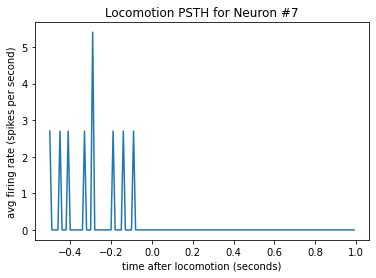

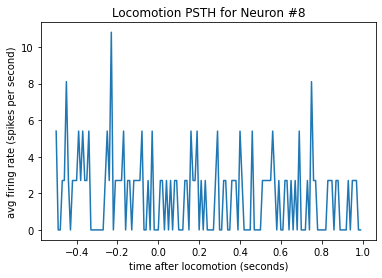

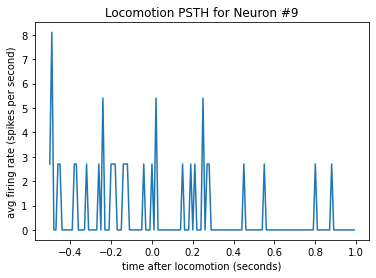

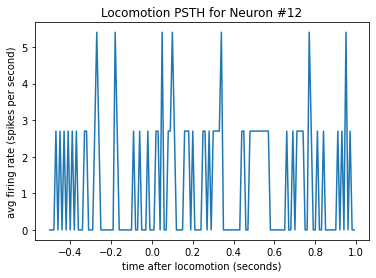

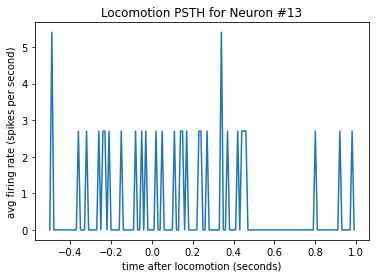

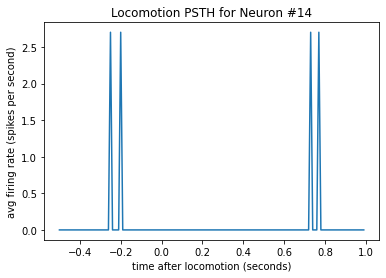

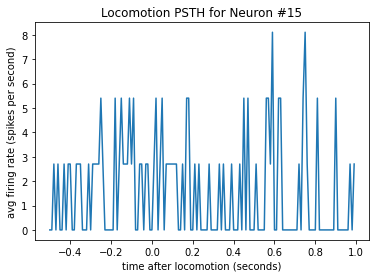

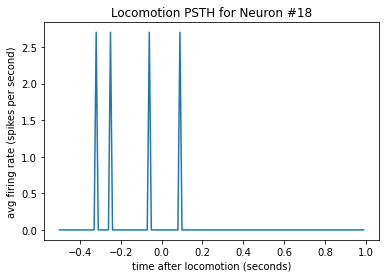

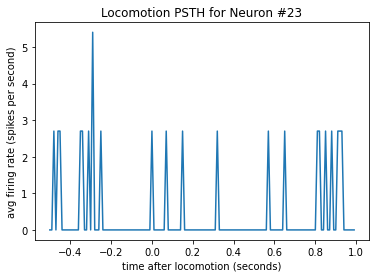

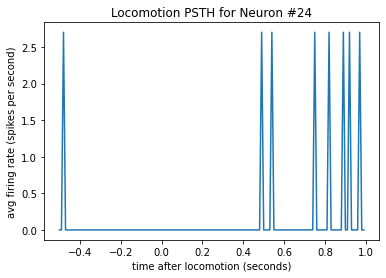

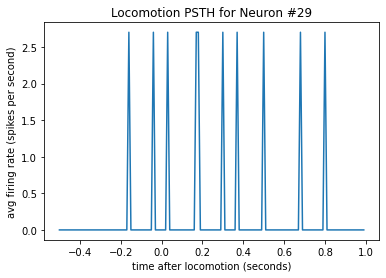

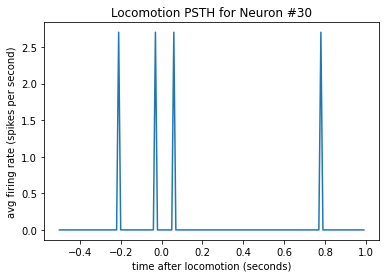

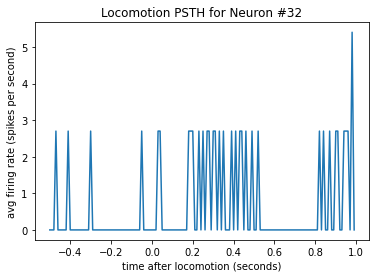

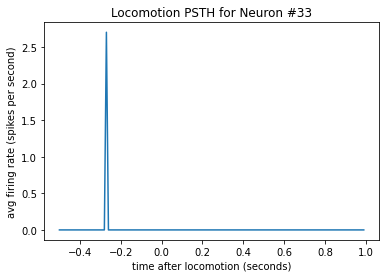

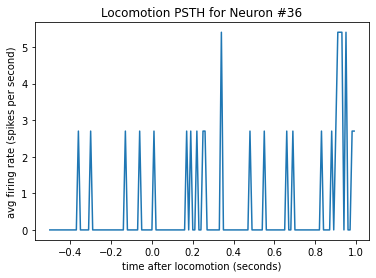

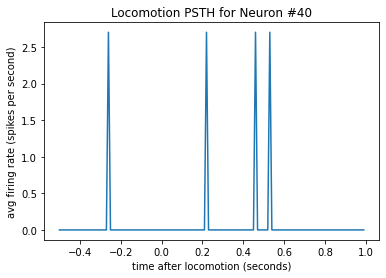

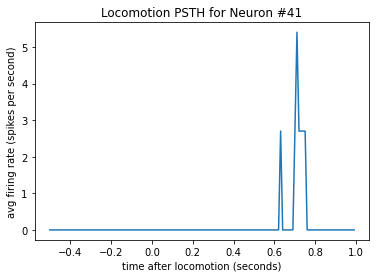

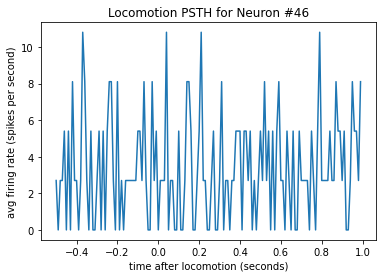

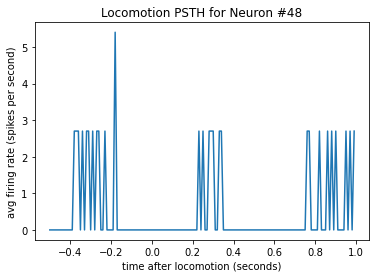

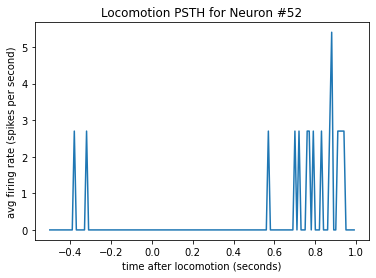

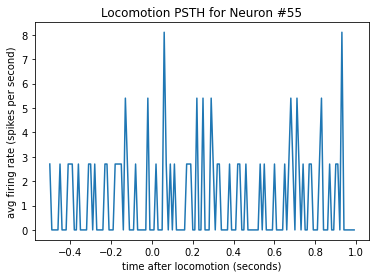

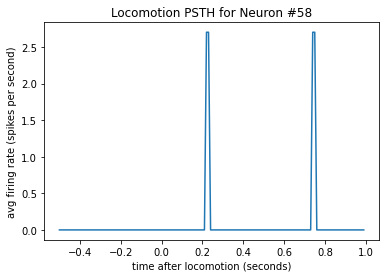

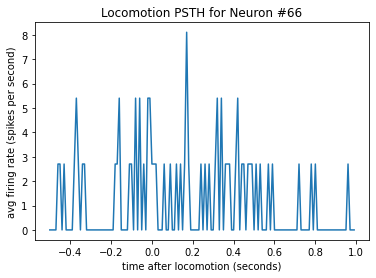

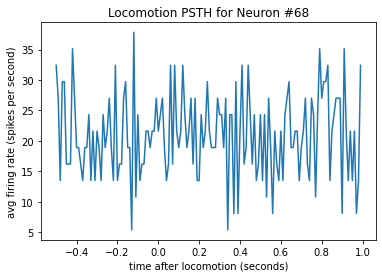

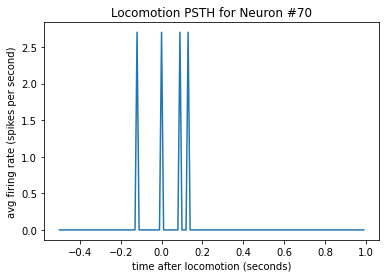

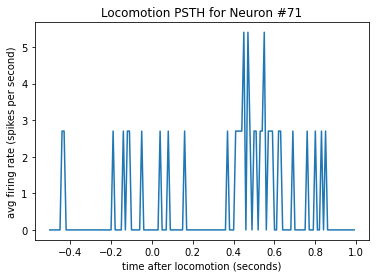

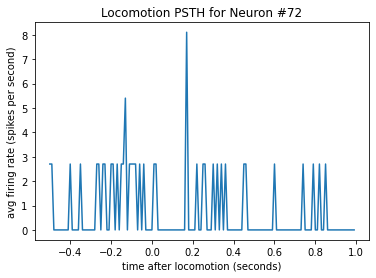

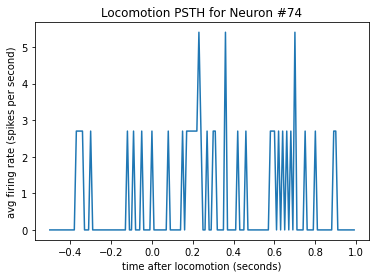

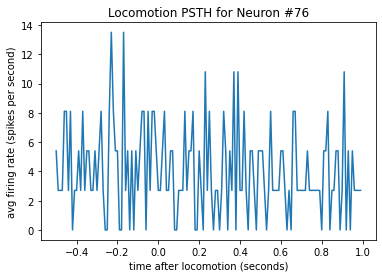

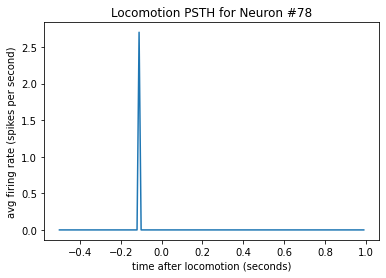

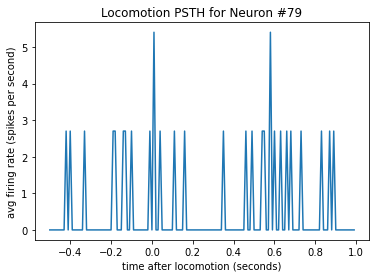

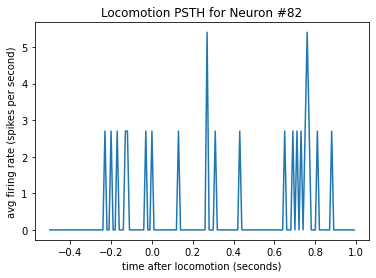

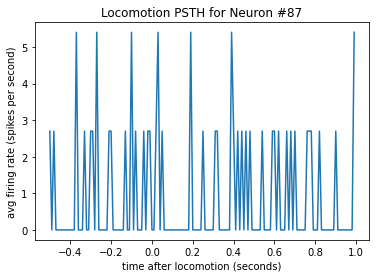

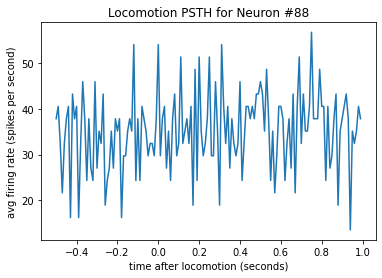

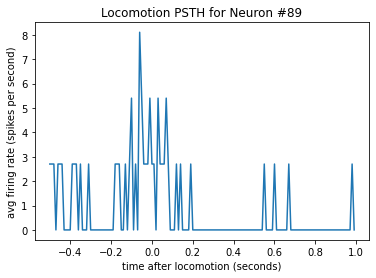

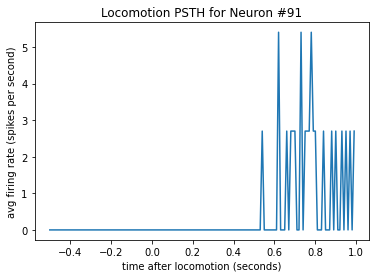

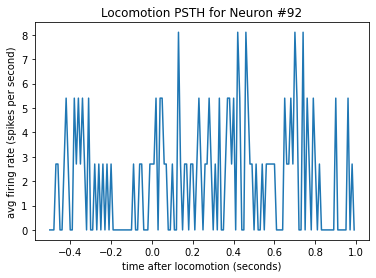

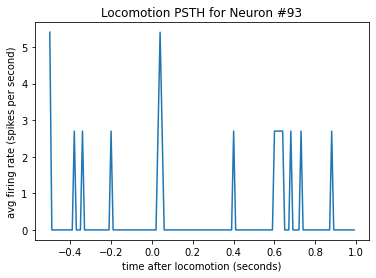

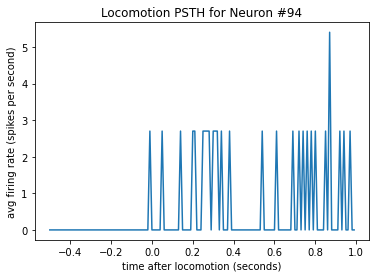

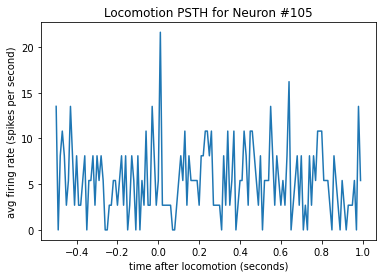

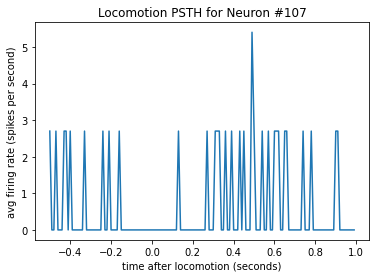

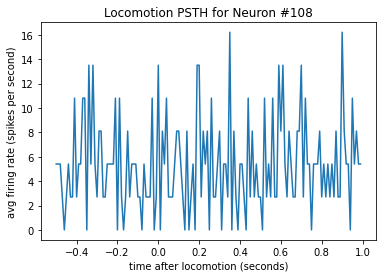

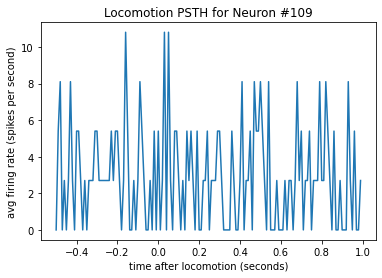

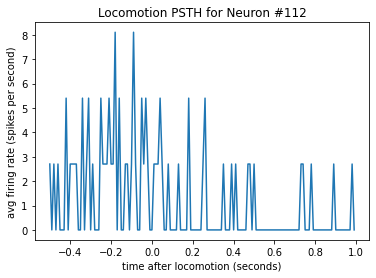

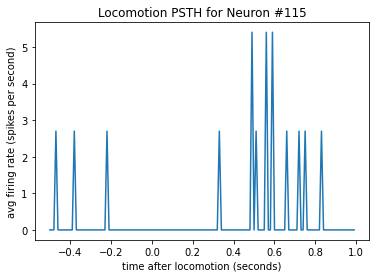

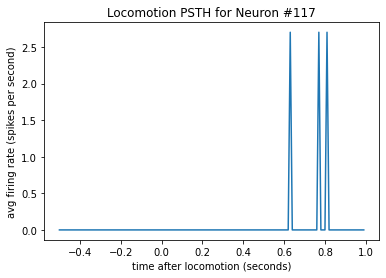

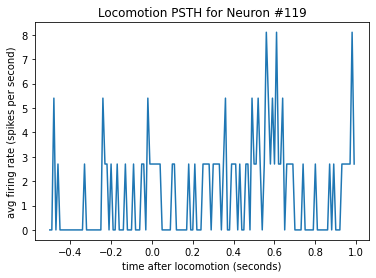

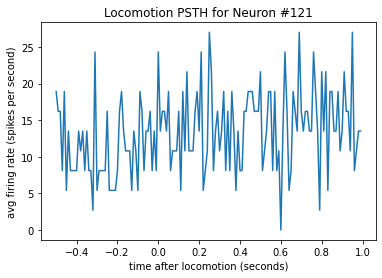

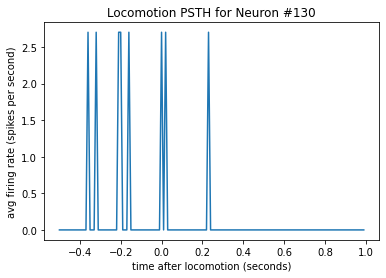

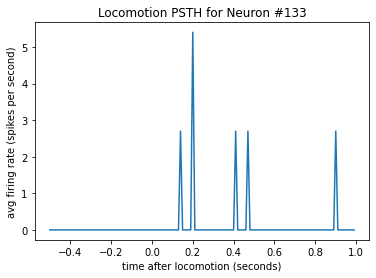

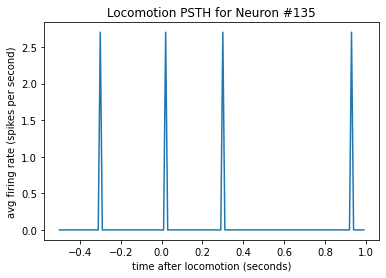

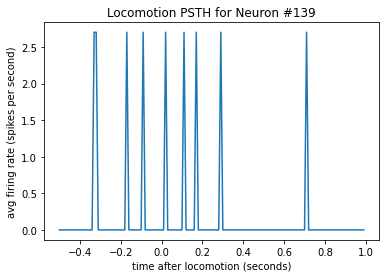

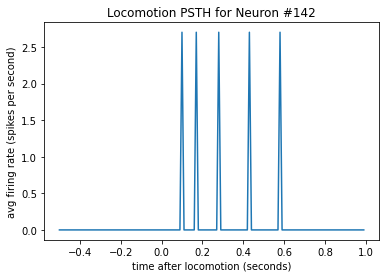

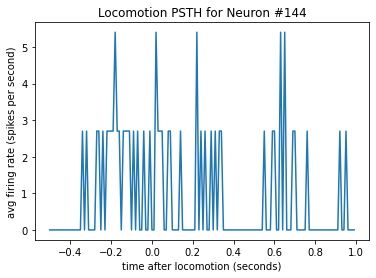

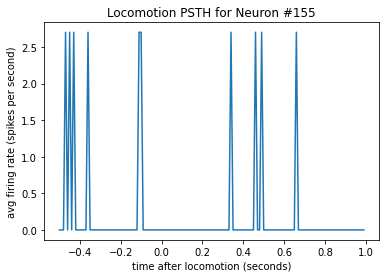

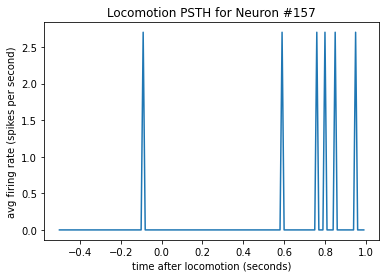

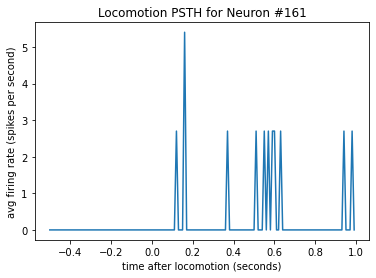

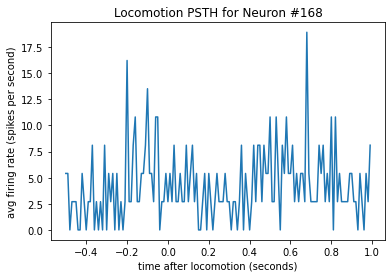

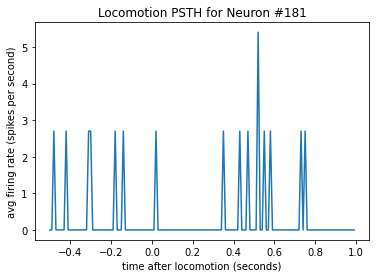

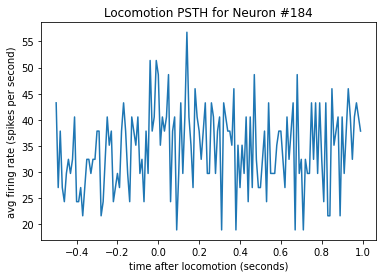

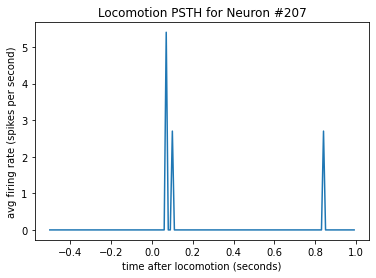

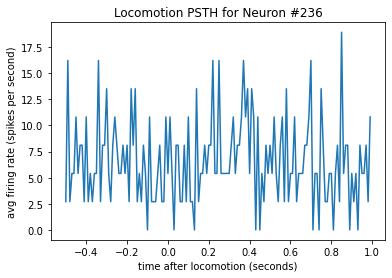

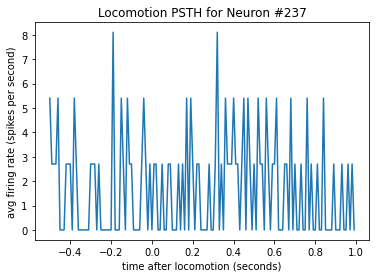

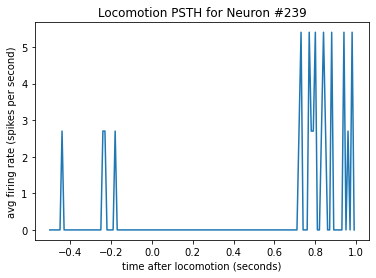

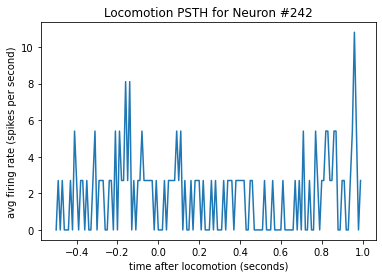

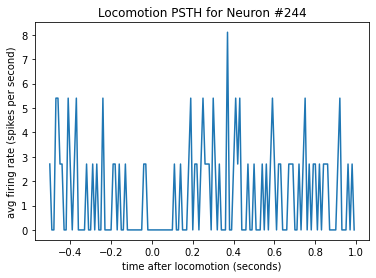

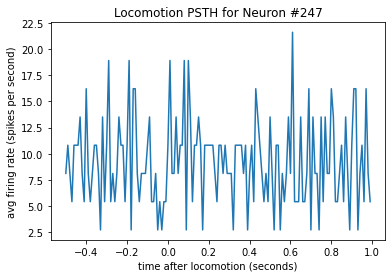

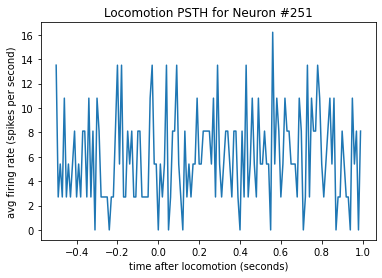

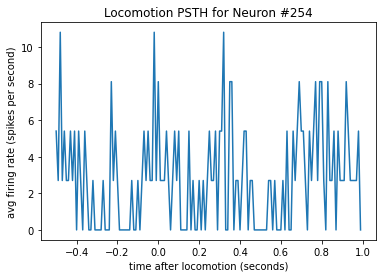

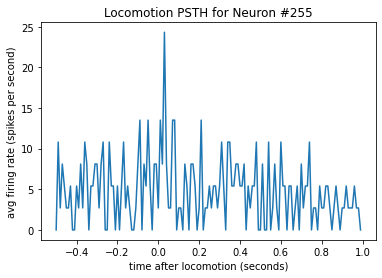

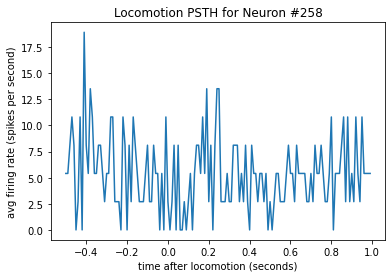

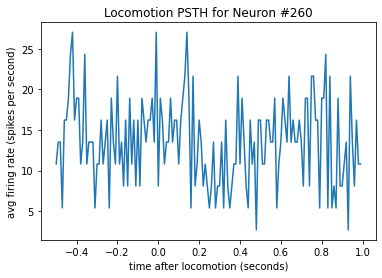

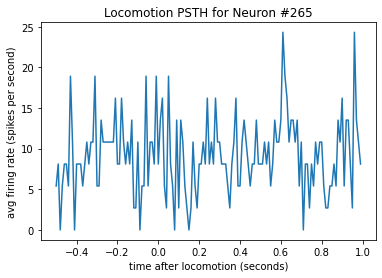

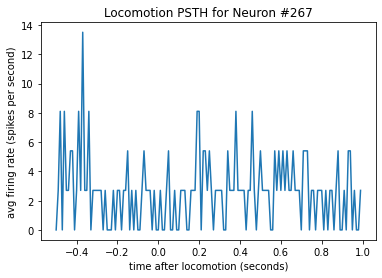

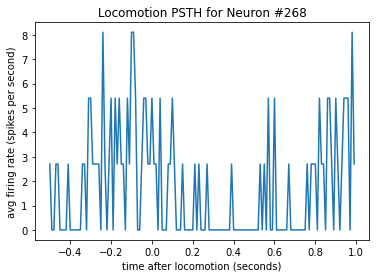

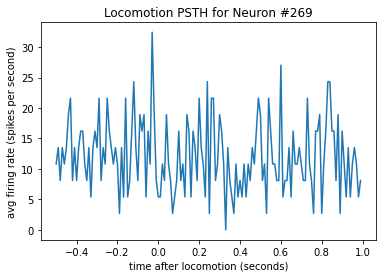

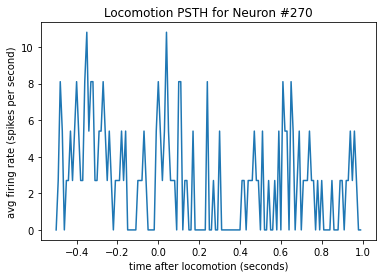

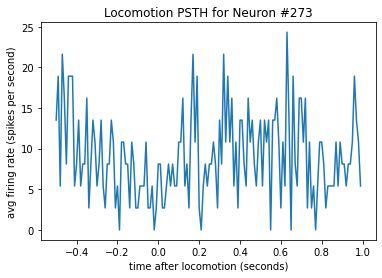

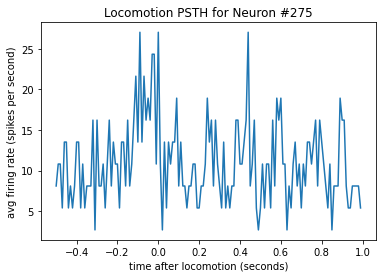

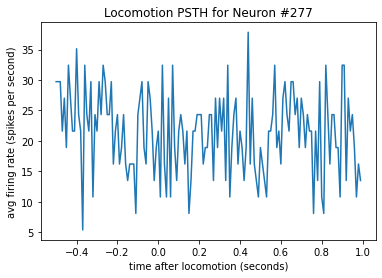

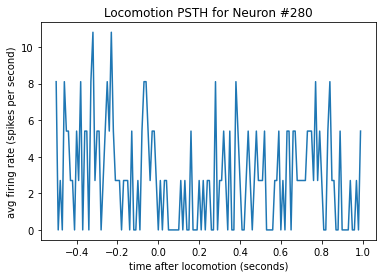

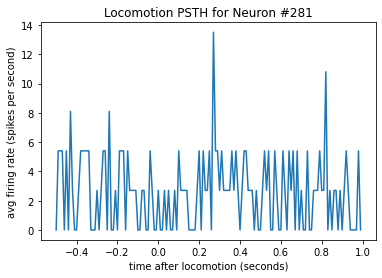

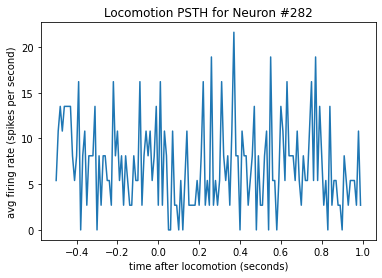

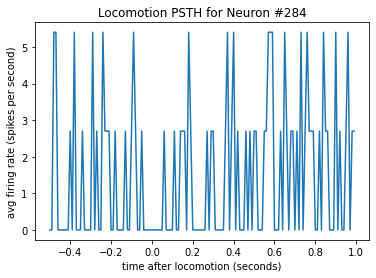

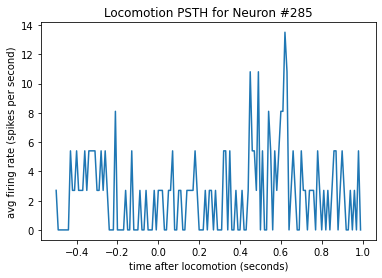

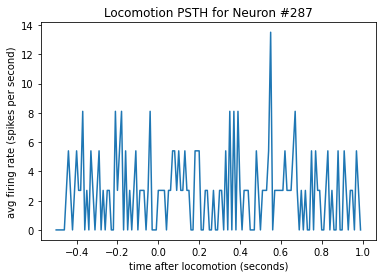

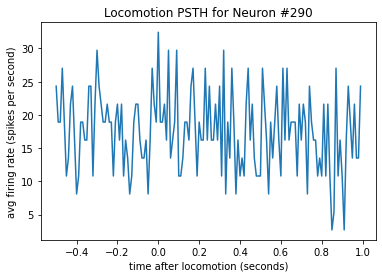

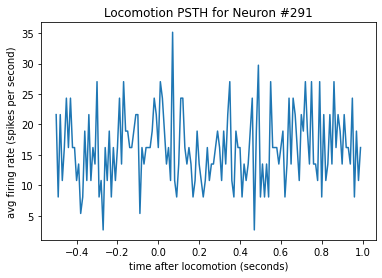

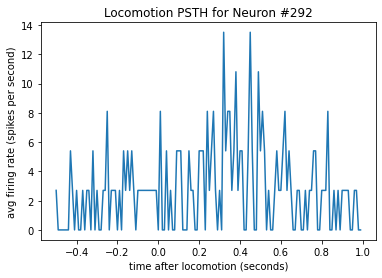

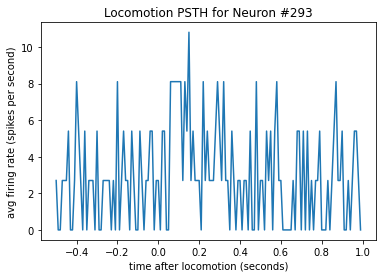

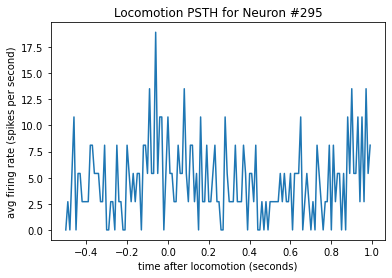

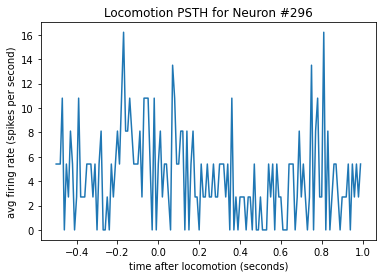

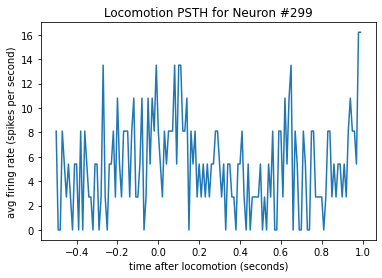

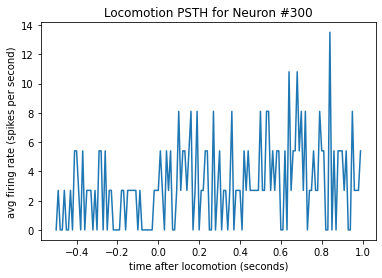

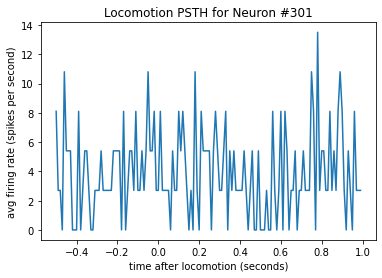

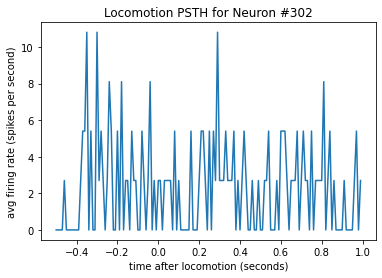

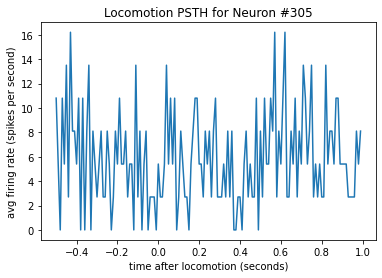

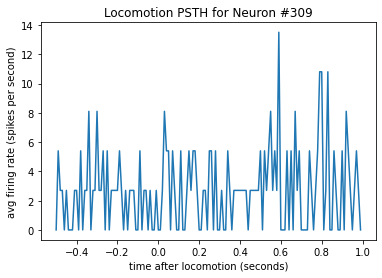

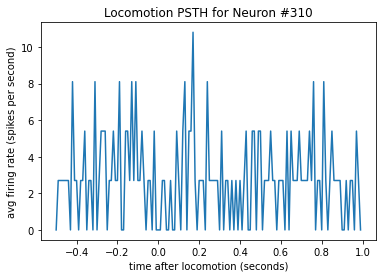

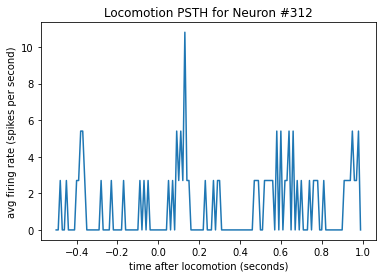

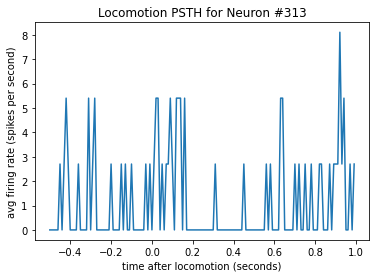

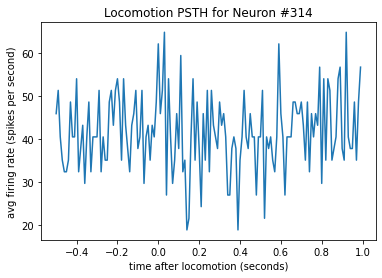

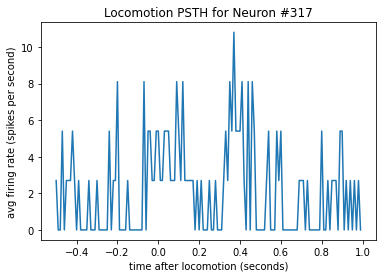

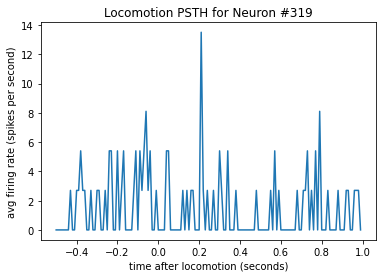

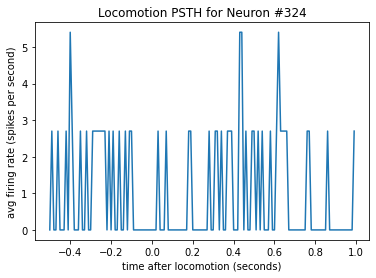

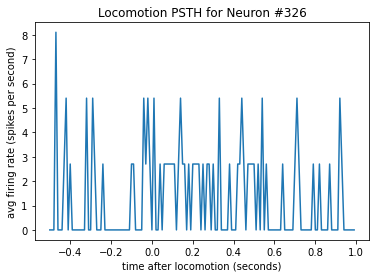

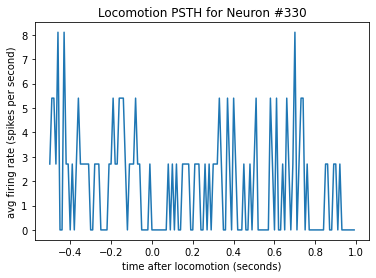

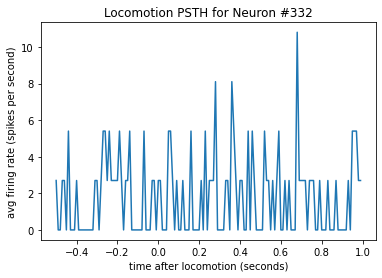

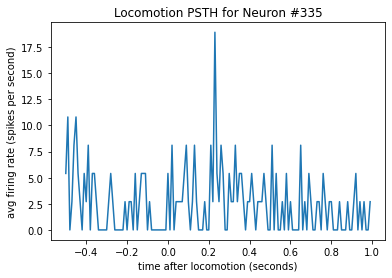

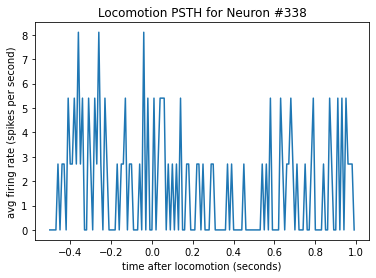

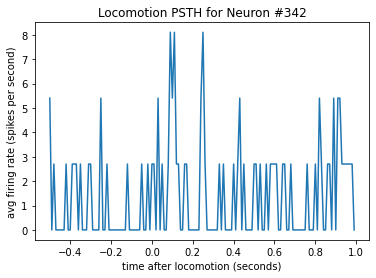

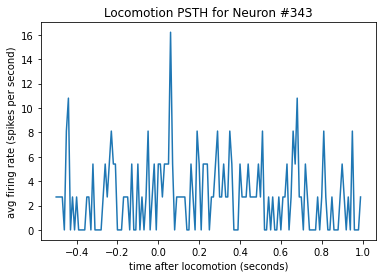

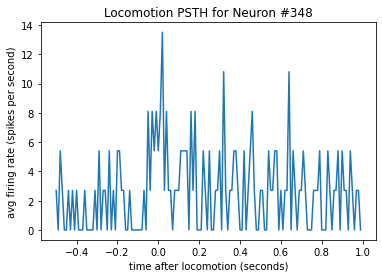

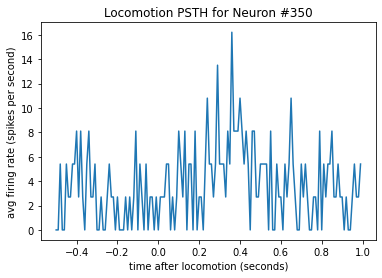

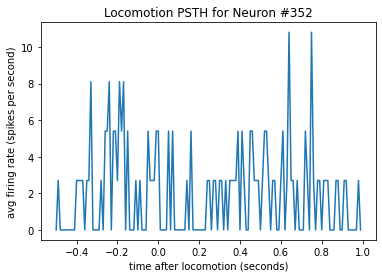

In [11]:
for neuron_id in psth_loco:
    ID = neuron_id
    plt.figure()
    plt.plot(bin_times, psth_loco[ID])
    plt.title('Locomotion PSTH for Neuron #'+str(ID))
    plt.ylabel('avg firing rate (spikes per second)')
    plt.xlabel('time after locomotion (seconds)')
plt.show()

In [ ]:
ID = 290
plt.figure()
plt.plot(bin_times, psth_loco[ID])
plt.title('Locomotion PSTH for Neuron #'+str(ID))
plt.ylabel('avg firing rate (spikes per second)')
plt.xlabel('time after locomotion (seconds)')
plt.show()

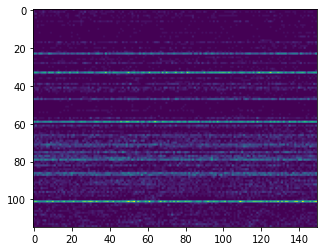

In [13]:
plt.imshow(psth_loco.T)

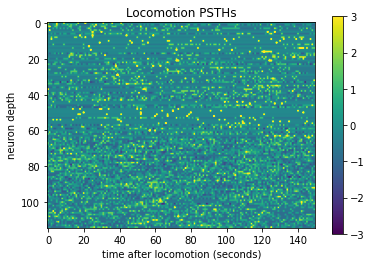

In [16]:
# all locomotion neuron PSTHs, plotted by neuron id number
psth_loco_zscored = psth_loco.apply(scipy.stats.zscore)

# plt.imshow(psth_loco_zscored.T, interpolation='none', extent=[-0.5, 1.0, len(psth_loco_zscored.columns), 0], 
#            aspect='auto', vmin= -1, vmax=2.5)
plt.imshow(psth_loco_zscored.T, vmin=-3, vmax=3)
plt.ylabel('neuron depth') 
plt.xlabel('time after locomotion (seconds)') 
plt.title('Locomotion PSTHs') 
plt.colorbar()
plt.show()

In [44]:

psth_loco_sorted = psth_loco_zscored.loc[:, psth_loco_zscored[40:60].mean().sort_values(ascending=False).keys()]

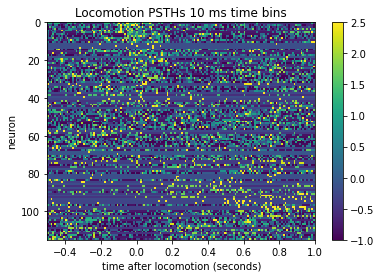

In [46]:
# psth_loco_sorted = psth_loco_zscored.loc[:,psth_loco_zscored[6:14].idxmean().sort_values().index]
plt.imshow(psth_loco_sorted.T, interpolation='none', extent=[-0.5, 1.0, len(psth_loco_sorted.columns), 0], 
           aspect='auto', vmin= -1, vmax = 2.5)
plt.ylabel('neuron') 
plt.xlabel('time after locomotion (seconds)') 
plt.title('Locomotion PSTHs 10 ms time bins') 
plt.colorbar()
plt.savefig('locomotion2.png')
plt.show()


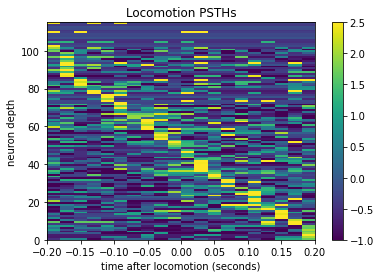

In [15]:
# 200 ms before to 200 ms after, all locomotion neuron PSTHs, plotted by neuron id number
plt.imshow(psth_loco_sorted.iloc[15:35].T, interpolation='none', extent=[-0.2, 0.2, 0, len(psth_loco_sorted.columns)], 
           aspect='auto', vmin= -1, vmax = 2.5)
plt.ylabel('neuron depth') 
plt.xlabel('time after locomotion (seconds)') 
plt.title('Locomotion PSTHs') 
plt.colorbar()
plt.show()

In [ ]:
# I HAVE NOT corrected the psth code for itch yet
# itch, 32 bouts
psth_list_4 = []
count = 0
for n, name in enumerate(name_list):
    if 'itch - start_time_1' in name:
        
        print(count)
        neural_LED_sincestart = video_Starttime[count] - cam4_start_seg1 + \
                                frames2LED_sincestart[count]/framerate - delay
        count += 1
        
        print(neural_LED_sincestart)

        for itch in behavior_list[n]['start_time']:
            print('itch : ', itch) 
            first_beh_since_neural_recording = neural_LED_sincestart + itch
            min_bound = np.where(spike_times/sample_rate >= first_beh_since_neural_recording + time_window[0])[0]
            max_bound = np.where(spike_times/sample_rate <= first_beh_since_neural_recording + time_window[1])[0]
        #         print(first_beh_since_neural_recording)
            d = {'spike_times': np.concatenate(
            spike_times[min_bound[0]:max_bound[-1]])/30000 - spike_times[min_bound[0]]/30000
                 , 'neuron_id': np.concatenate(clusters[min_bound[0]:max_bound[-1]])}
#                 print(d)
            df = pd.DataFrame(data=d)
            psth_list_4.append(df)
        

In [ ]:
# make PSTHs for itch

psth_itch = pd.DataFrame(np.zeros((30, len(good_clusters))), columns=good_clusters)

for df in psth_list_4:
    for neuron_id in df['neuron_id'].unique():
        if neuron_id in good_clusters:
            neuron_spike_times = df[df['neuron_id']==neuron_id]['spike_times']
            counts,_ = np.histogram(neuron_spike_times, bins = np.arange(0, 1.501, bin_width))
            for col in psth_itch:
                if col == neuron_id:
                    psth_itch[col] += counts/(len(psth_list_4))/bin_width
                    
psth_itch = psth_itch.loc[:, (psth_itch.sum(axis=0) > 0)]                    

In [ ]:
psth_itch

In [ ]:
plt.imshow(psth_itch.T, vmin = 0.2, vmax = 3)

In [ ]:
# all itch neuron PSTHs, plotted by neuron id number
psth_itch_zscored = psth_itch.apply(scipy.stats.zscore)


plt.imshow(psth_itch_zscored.T, interpolation='none', extent=[-0.5, 1.0, len(psth_itch_zscored.columns), 0], 
           aspect='auto', vmax=3)
plt.ylabel('neuron depth') 
plt.xlabel('time after itch (seconds)') 
plt.title('Itch PSTHs') 
plt.colorbar()
plt.show()

In [ ]:
# 200 ms before to 200 ms after, all itch neuron PSTHs, plotted by neuron id number
#bins 6-14

plt.imshow(psth_itch_zscored.iloc[6:14].T, interpolation='none', extent=[-0.2, 0.2, len(psth_itch_zscored.columns), 0], 
           aspect='auto', vmax=3)
plt.ylabel('neuron depth') 
plt.xlabel('time after itch (seconds)') 
plt.title('Itch PSTHs') 
plt.colorbar()
plt.show()

In [ ]:
# DELETE ALL THIS LATER
# previous incorrect versions of the PSTHs can be deleted once confident new version is correct

# psth_groom = pd.DataFrame()
# #psth_groom_indv = pd.DataFrame()

# for df in psth_list:
    
#     for neuron_id in df['neuron_id'].unique():
        
#         if neuron_id in good_clusters:
#             neuron_spike_times = df[df['neuron_id']==neuron_id]['spike_times']
#             #print(neuron_spike_times)
#             psth_groom[neuron_id] = [0]*bin_count
#             counts,_ = np.histogram(neuron_spike_times, bins = np.arange(0, 1.501, bin_width))
#             #print(counts)
#             #psth_groom_indv = [0]*bin_count
#             #counts2 = np.divide(counts, bin_width)
#             #print(counts2)
#             #counts2s = pd.Series(counts2)
#             #counts2_list = counts2.tolist()
#             #print(counts2_list)
#             psth_groom[neuron_id] += counts/(len(psth_list))/bin_width
#             #psth_groom_indv[neuron_id].append(counts2s)
            
            
# psth_groom_a = pd.DataFrame()
# psth_groom_h = pd.DataFrame()
# psth_groom_s = pd.DataFrame()
# psth_groom_b = pd.DataFrame()

# for df in psth_list:
#     df_a = df[df['behavior'] == 'a']
#     for neuron_id in df_a['neuron_id'].unique():
#         if neuron_id in good_clusters:
#             neuron_spike_times = df_a[df_a['neuron_id']==neuron_id]['spike_times']
#             print(neuron_spike_times)
#             psth_groom_a[neuron_id] = [0]*bin_count
#             counts,_ = np.histogram(neuron_spike_times, bins = np.arange(0, 1.501, bin_width))
#             psth_groom_a[neuron_id] += counts/(len(psth_list))/bin_width
        
#     df_h = df[df['behavior'] == 'h']
#     for neuron_id in df_h['neuron_id'].unique():
#         if neuron_id in good_clusters:
#             neuron_spike_times = df_h[df_h['neuron_id']==neuron_id]['spike_times']
#             print(neuron_spike_times)
#             psth_groom_h[neuron_id] = [0]*bin_count
#             counts,_ = np.histogram(neuron_spike_times, bins = np.arange(0, 1.501, bin_width))
#             psth_groom_h[neuron_id] += counts/(len(psth_list))/bin_width  
    
#     df_s = df[df['behavior'] == 's']
#     for neuron_id in df_s['neuron_id'].unique():
#         if neuron_id in good_clusters:
#             neuron_spike_times = df_s[df_s['neuron_id']==neuron_id]['spike_times']
#             print(neuron_spike_times)
#             psth_groom_s[neuron_id] = [0]*bin_count
#             counts,_ = np.histogram(neuron_spike_times, bins = np.arange(0, 1.501, bin_width))
#             psth_groom_s[neuron_id] += counts/(len(psth_list))/bin_width    
            
#     df_b = df[df['behavior'] == 'b']
#     for neuron_id in df_b['neuron_id'].unique():
#         if neuron_id in good_clusters:
#             neuron_spike_times = df_b[df_b['neuron_id']==neuron_id]['spike_times']
#             print(neuron_spike_times)
#             psth_groom_b[neuron_id] = [0]*bin_count
#             counts,_ = np.histogram(neuron_spike_times, bins = np.arange(0, 1.501, bin_width))
#             psth_groom_b[neuron_id] += counts/(len(psth_list))/bin_width
            